<a href="https://colab.research.google.com/github/krystianjablonowski/kwant-tutorials-zps/blob/master/_notebooks/1999-03-20-Haldane%20-%20Haldane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install kwant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for kwant: filename=kwant-1.4.3-cp39-cp39-linux_x86_64.whl size=5576655 sha256=c3b3d436243c24139b99db86103a1945546796eee3089a39171e6d1d0530a11d
  Stored in directory: /root/.cache/pip/wheels/97/41/05/b653e2602ddc2a7ea47b49beb24e9a247cba7ef27d3b3093cc
  Created wheel for tinyarray: filename=tinyarray-1.2.4-cp39-cp39-linux_x86_64.whl size=268633 sha256=37b25d69ee5ea89bcfe351d4d714bce924a77b77f33b112208b73c50672f58bb
  Stored in directory: /root/.cache/pip/wheels/77/99/a6/a67f1be933081998661268d20a1d38dd1dff3fd60a05404b76
Successfully built kwant tinyarray


In [11]:
import kwant
from matplotlib import pyplot as plt
import tinyarray as ta
import numpy as np
import scipy.sparse.linalg as sla
import scipy


import scipy as scp


from kwant.physics import dispersion
from numpy.linalg import eig

In [12]:
def make_system_noleads(a=1, t_1=1.0, t_2=1.0, L=10, r=3):
    def circle(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return rsq < r ** 2
       

    
  
    R = np.array([[np.sqrt(3)/2, 1/2],[-1/2, np.sqrt(3)/2]])

    v_1 = [3*a/2, np.sqrt(3)*a/2]
    v_2 = [3*a/2, -np.sqrt(3)*a/2]
    
    r_1 = [0,0]
    r_2 = [a,0]
    
    lat = kwant.lattice.Polyatomic([np.dot(R,v_1), np.dot(R,v_2)], [np.dot(R,r_1), np.dot(R,r_2)],norbs=1)

    lat.a, lat.b = lat.sublattices
    
    syst = kwant.Builder()
    onsite = 0
    # Onsites
    syst[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
    syst[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
    # Hopping
    hoppings = (((0, a), lat.a, lat.b), 
                ((a, 0), lat.a, lat.b), 
                ((-a/2, -np.sqrt(3)*a/2), lat.a, lat.b),
                ((-a/2, np.sqrt(3)*a/2), lat.a, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
    hoppings2_a = (((0, a), lat.a, lat.a), ((a, 0), lat.a, lat.a), ((a, -a), lat.a, lat.a))
    #hoppings2_a = (((a/2, 3*a/2), lat.a, lat.a))
    hoppings2_b = (((0, a), lat.b, lat.b), ((a, 0), lat.b, lat.b), ((a, -a), lat.b, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2

    
    return syst.finalized()


In [20]:
from ipywidgets import *

def SSH_energy(v,w,c):
  syst = make_system_noleads(a=1, t_1=v, t_2=1j*c, L=5, r=3)
  hamiltonian = syst.hamiltonian_submatrix(sparse=False)
  w1,v1=eig(hamiltonian)
  plt.plot(np.arange(0,50,1),sorted(np.real(w1)),'.')
  plt.axhline(y = 0, color = 'r', linestyle = '-')
  plt.show()

interact(SSH_energy,v=(0.0,5,0.1),w=(0.0,5,0.1),c=(-np.pi,np.pi,0.1));

interactive(children=(FloatSlider(value=2.5, description='v', max=5.0), FloatSlider(value=2.5, description='w'…

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_DOS3(v,w,c):
    fig, ax = plt.subplots(figsize=[5, 4])
    syst = make_system_noleads(a=1, t_1=v, t_2=w*np.exp(1j*c), L=5, r=3)
    hamiltonian = syst.hamiltonian_submatrix(sparse=False)

    w1,v1=eig(hamiltonian)
    rho = kwant.kpm.SpectralDensity(hamiltonian, rng=0)
    w1, densities = rho()
    density_subset = np.real(rho(w1))
    ax.plot(w1,density_subset)

    # generate inset axes
    axins = zoomed_inset_axes(ax, 5, loc='upper center')  # zoom = 5

    # plot in the inset axes
    axins.scatter(w1,density_subset, s=2)

    # fix the x, y limit of the inset axes
    axins.set_xlim(-max(w1)/10, max(w1)/10)
    axins.set_ylim(0, max(density_subset)/20)

    # fix the number of ticks on the inset axes
    axins.yaxis.get_major_locator().set_params(nbins=1)
    axins.xaxis.get_major_locator().set_params(nbins=1)

interact(plot_DOS3,v=(0.0,5,0.1),w=(0.0,5,0.1),c=(-np.pi,np.pi,0.1))

interactive(children=(FloatSlider(value=2.5, description='v', max=5.0), FloatSlider(value=2.5, description='w'…

<function __main__.plot_DOS3(v, w, c)>

In [15]:
def make_system(a=1, t_1=1.0, t_2=1.0, L=10, r=3):
    def circle(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return rsq < r ** 2
        #return x>=-L//2 and x<<L//2 and y<=L//2 and y>=-L//2

    
    #lat = kwant.lattice.Polyatomic([[3*a/2, np.sqrt(3)*a/2], [3*a/2, -np.sqrt(3)*a/2]], [[0, 0], [a,0]])
    R = np.array([[np.sqrt(3)/2, 1/2],[-1/2, np.sqrt(3)/2]])

    v_1 = [3*a/2, np.sqrt(3)*a/2]
    v_2 = [3*a/2, -np.sqrt(3)*a/2]
    
    r_1 = [0,0]
    r_2 = [a,0]
    
    lat = kwant.lattice.Polyatomic([np.dot(R,v_1), np.dot(R,v_2)], [np.dot(R,r_1), np.dot(R,r_2)],norbs=1)

    lat.a, lat.b = lat.sublattices
    
    syst = kwant.Builder()
    onsite = 0
    # Onsites
    syst[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
    syst[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
    # Hopping
    hoppings = (((0, a), lat.a, lat.b), 
                ((a, 0), lat.a, lat.b), 
                ((-a/2, -np.sqrt(3)*a/2), lat.a, lat.b),
                ((-a/2, np.sqrt(3)*a/2), lat.a, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
    hoppings2_a = (((0, a), lat.a, lat.a), ((a, 0), lat.a, lat.a), ((a, -a), lat.a, lat.a))
    #hoppings2_a = (((a/2, 3*a/2), lat.a, lat.a))
    hoppings2_b = (((0, a), lat.b, lat.b), ((a, 0), lat.b, lat.b), ((a, -a), lat.b, lat.b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2

    
    LEADS = True
    if LEADS:
        # Right lead
        sym_right_lead = kwant.TranslationalSymmetry(np.dot(R,[-3*a/2, -np.sqrt(3)*a/2]))
        #sym_right_lead = kwant.TranslationalSymmetry([2*a,0])
        right_lead = kwant.Builder(sym_right_lead)
        right_lead[(lat.a(n, m) for n in range(L) for m in range(L))] = onsite
        right_lead[(lat.b(n, m) for n in range(L) for m in range(L))] = onsite
        
        # Hopping
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = t_1
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_a]] = t_2
        right_lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2_b]] = t_2
        
        syst.attach_lead(right_lead)
        right_lead_fin = right_lead.finalized()
        
        syst.attach_lead(right_lead.reversed())
    syst_fin = syst.finalized()
    
    if(LEADS):
        return syst_fin, right_lead_fin
    else:
        return syst_fin

def plot_bandstructure(flead, momenta, label=None, title=None):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]
    
    plt.figure()
    plt.title(title)
    plt.plot(momenta, energies, label=label)
    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [t]")

def plot_conductance(syst, energies):
    # Compute conductance
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(1, 0))

    plt.figure()
    plt.plot(energies, data)
    plt.xlabel("energy [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()

def plot_density(sys,ener, it=-1):
    
    wf = kwant.wave_function(sys, energy=ener)
    
    t=np.shape(wf(0))
    nwf=wf(0)[0]*0
    
    
    for i in range(t[0]//2+1):
        test=wf(0)[i]
        nwf+=test

    psi=abs(nwf)**2
    
    if it==-1:
        title="density"
    elif it>-1:
        title= "density"
        
    title2=title+".pdf"
    
    kwant.plotter.map(sys,psi,method='linear',vmin=0)

    J_0 = kwant.operator.Current(sys)
    c = J_0(nwf)

    kwant.plotter.current(sys, c)


    plt.close()




In [ ]:

# sys, right_lead = make_system(t_1 = 1, t_2 = 0.5*np.exp(1j))
# kwant.plot(sys)
# kwant.plot(sys, file='haldane.pdf')

# #plot_conductance(sys, np.linspace(0,2,1000))
# plot_density(sys, 1)

# for phi in np.linspace(2*np.pi/5, 3*np.pi/2, 10):
#     t_2 = 0.1 * np.exp(1j*phi)
#     sys, right_lead = make_system(t_1 = 1, t_2 = t_2)
#     plot_bandstructure(right_lead, np.linspace(-np.pi, np.pi, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")
#     plt.savefig(f't_1 = 1 t_2 = {round(t_2,4)}.pdf')
# plt.show()


# R = np.array([[1/np.sqrt(2), 1/np.sqrt(2)],[-1/np.sqrt(2), 1/np.sqrt(2)]])
# print(np.dot(R,[1,0]))

In [16]:


def plot_spectrum(t_1,t_2,c):
    #t_2 = t_2 * np.exp(1j*c)
    sys, right_lead = make_system(t_1 = t_1, t_2 = t_2*np.exp(1j*c))
    plot_bandstructure(right_lead, np.linspace(-np.pi, np.pi, 100), t_2, title=f"t_1 = 1, t_2 = {t_2}")

interact(plot_spectrum,t_1=(0.0,5,0.1),t_2=(0.0,5,0.1),c=(-np.pi,np.pi,0.1))

interactive(children=(FloatSlider(value=2.5, description='t_1', max=5.0), FloatSlider(value=2.5, description='…

<function __main__.plot_spectrum(t_1, t_2, c)>

In [17]:

def plot_conductance(t_1,t_2,c):
    sys, right_lead = make_system(t_1 = t_1, t_2 = t_2*np.exp(1j*c))
    plot_density(sys, 1)

interact(plot_conductance,t_1=(0.0,5,0.1),t_2=(0.0,5,0.1),c=(-np.pi,np.pi,0.1))

interactive(children=(FloatSlider(value=2.5, description='t_1', max=5.0), FloatSlider(value=2.5, description='…

<function __main__.plot_conductance(t_1, t_2, c)>

In [18]:
def plot_probability(ham):
    phi_tab = np.linspace(0, 2*np.pi, 10)
    energies = []
    for phi in phi_tab:
        sys = make_system(t_1 = 1, t_2 = np.exp(1j*phi))
        ham = sys.hamiltonian_submatrix(sparse=True)
        e_val, e_vec = scipy.sparse.linalg.eigsh(ham, k=197, return_eigenvectors=True)
        e_val = np.sort(e_val)
        energies.append(e_val)
        
    plt.figure()
    plt.plot(phi_tab, energies)
    plt.xlabel("t2")
    plt.ylabel("energy [t]")
    plt.show()
    
syst = make_system_noleads(a=1, t_1=1, t_2=5*np.exp(1j*2), L=5, r=3)
hamiltonian = syst.hamiltonian_submatrix(sparse=False)
plot_probability(hamiltonian)
    

AttributeError: ignored

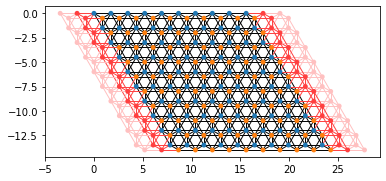

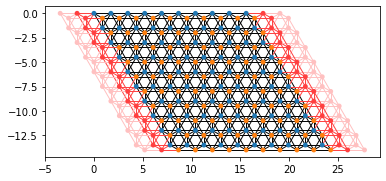

In [19]:
sys, left_lead = make_system()
kwant.plot(sys)